Training a Recurrent Neural Network on Google Colab TPU
----

This notebook implements a moderately sized (~300,000 parameters) LTSM RNN to identify fraudulent credit card transactions in a synthetic dataset. However, the results are unimpressive: an PR-AUC of under 0.1 on training data and 0 on test data.

Some possible strategies:
1. Build a simple feed-forward model as a comparison point.
1. Make a two-track network: one that does that is feed-forward on each transaction, and one that is recurrent on the sequence.
1. Instead of trying to run a distributed RNN on the entire sequence, create fixed windows of some number of transactions (say, a few hundred) to classify just the final transaction. This could be combined with a separate track for the characteristics of the transaction itself.



# Setup

## Imports

In [ ]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from typing import Tuple, Union, List
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from google.colab import drive
# sys.path.append("../src")

## Mounting Drive

In [ ]:
drive_root = '/gdrive'
drive.mount(drive_root)
project_folder = drive_root + '/My Drive/learning/Data Science/Springboard/Capstone Projects/2/rnn'
train_data_path = project_folder + '/tx_train_set.csv'
test_data_path = project_folder + '/tx_test.csv'
mcc_rates_path = project_folder + '/mcc_rates.csv'
output_path = project_folder + '/fraud_prediction_rnn.h5'

Mounted at /gdrive


## TPU setup

In [ ]:
tf.keras.backend.clear_session()

resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
# or: tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
tf.config.experimental_connect_to_cluster(resolver)

# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.TPUStrategy(resolver)

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


# Preprocessing

## Transformer classes

In [ ]:
def convert_multicat(df: pd.DataFrame, colname: str, copy:bool=True) -> Tuple[pd.DataFrame, List[str]]:
    '''(Optionally copies `df` and) converts the categorical column `colname` into dummies. Allows for membership in multiple categories separated by a single comma, e.g. entry "a,b" will be converted into `True` for columns `a` and `b`'''
    if copy:
        dummy_df = df.copy()
    else:
        dummy_df = df
    cats = set()
    for entry in dummy_df[colname].dropna().unique().tolist():
        for cat in entry.split(','):
            cats.add(cat)
    cats = list(cats)
    for cat in cats:
        dummy_df[cat] = dummy_df[colname].str.contains(cat).fillna(False)
    dummy_df.drop(columns=colname, inplace=True)

    return dummy_df, cats



class MakeDummies(BaseEstimator, TransformerMixin):
    """Transforms categorical columns into dummies. Can handle multi-category columns"""
    def __init__(self, multicat_col: str, drop_first=True, dummy_cols:Union[List[str], str]='auto') -> None:
        super().__init__()
        self.multicat_col = multicat_col
        self.drop_first = drop_first
        self.dummy_cols= dummy_cols

    def fit(self, X, y=None):
        _, self.cats = convert_multicat(X, self.multicat_col)
        return self

    def fit_transform(self, X, y=None):
        dummy_df, self.cats = convert_multicat(X, self.multicat_col)
        dummy_df = pd.get_dummies(dummy_df, drop_first=self.drop_first)
        return dummy_df

    def transform(self, X, y=None):
        dummy_df = X.copy()
        for cat in self.cats:
            dummy_df[cat] = dummy_df[self.multicat_col].str.contains(cat).fillna(False)
        dummy_df.drop(columns=self.multicat_col, inplace=True)
        dummy_df = pd.get_dummies(dummy_df, drop_first=self.drop_first)

        return dummy_df



class MCCRates(BaseEstimator, TransformerMixin):
    """Transforms MCC codes into average fraud rates, based on saved data or a specific training set. Note: only accepts data frames"""

    mcc_rates_path = mcc_rates_path

    def __init__(self, use_saved=None) -> None:
        super().__init__()
        self.mcc_rates = pd.read_csv(use_saved, index_col=0) if use_saved else None

    def fit(self, X, y=None):
        if self.mcc_rates is None:
            self.mcc_rates = (
                X.copy()
                .groupby('mcc')
                .agg('mean')
                .rename({'mean':'mcc_fraud_rate'}, axis=1)
            )
        return self

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def transform(self, X, y=None):
        X_transformed = X.merge(self.mcc_rates, how='left', left_on='mcc', right_index=True)
        X_transformed.drop(columns='mcc', inplace=True)
        return X_transformed

## Creating the datasets

In [ ]:
# load balanced training data and test data
training_data = pd.read_csv(train_data_path, index_col=0)
testing_data = pd.read_csv(test_data_path, index_col=0)

mcc_converter = MCCRates(mcc_rates_path)
dummy_converter = MakeDummies('errors')

y_train = training_data[['user', 'is_fraud']].copy()
X_train = mcc_converter.fit_transform(training_data.drop(columns=['is_fraud','card']))
# X_train = mcc_converter.fit_transform(training_data)
X_train = dummy_converter.fit_transform(X_train)

y_test = testing_data[['user', 'is_fraud']].copy()
X_test = mcc_converter.transform(testing_data.drop(columns=['is_fraud','card']))
X_test = dummy_converter.transform(X_test)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
X_train.head().T

,2001,2005,2018,2028,2031
user,22,22,22,22,22
amount,149.42,2.32,61.4,41.87,12.59
has_chip,True,True,True,True,True
cards_issued,2,2,2,2,2
credit_limit,4488.0,4488.0,4488.0,4488.0,4488.0
latitude,41.47,41.47,41.47,41.47,41.47
longitude,-81.67,-81.67,-81.67,-81.67,-81.67
per_capita_income_zipcode,19524.0,19524.0,19524.0,19524.0,19524.0
yearly_income_person,41109.0,41109.0,41109.0,41109.0,41109.0
total_debt,21486.0,21486.0,21486.0,21486.0,21486.0


Keras RNNs take 3-d arrays of shape $(N, L, D)$, where $L$ is a fixed sequence length. Observations with shorter sequences should be "padded" to the right with 0 vectors. These can then be processed by a `Mask(mask_value=0.0, input_shape=(L,D))` layer, which will output a boolean matrix of size $(N,L)$ indicating which sequence entries are real observations. There is a utility function for padding, but only seems to work with 1d sequences.

In [ ]:
batch_size = 4 * strategy.num_replicas_in_sync
print(f"Batch size: 4*{strategy.num_replicas_in_sync}={batch_size}")

def make_rnn_sequences(X:pd.DataFrame, y:pd.DataFrame, max_length:int, subset_size=None):
    features = X.shape[1] - 1 # subtracting the user column
    users = X.user.unique()
    n_users = subset_size if subset_size else len(users)
    X_seq = np.zeros((n_users, max_length, features), dtype=np.float32)
    y_seq = np.zeros((n_users, max_length, 1), dtype=np.float32)
    mask = np.full((n_users, max_length), False)
    for i, user in enumerate(users[:n_users]):
        seq_length = len(X[X.user==user])
        X_seq[i, :seq_length, :] = X[X.user==user].drop(columns=['user']).to_numpy(copy=True)
        y_seq[i, :seq_length, 0] = np.where(y[X.user==user].is_fraud, 1., 0.)
        mask[i, :seq_length] = True
    return X_seq, y_seq, mask.reshape(-1)


max_train_length = X_train.groupby('user')['amount'].agg('count').max()
max_test_length = X_test.groupby('user')['amount'].agg('count').max()
max_length = max(max_test_length, max_train_length)

X_seq_train, y_seq_train, train_mask = make_rnn_sequences(X_train, y_train, max_length)
X_seq_test, y_seq_test, test_mask = make_rnn_sequences(X_test, y_test, max_length)
positive_training_share = np.sum(y_seq_train) / np.product(y_seq_train.shape)
training_weights = np.where(y_seq_train, 1./positive_training_share, 1.).astype(np.float32)

n_train, seq_length, num_cols = X_seq_train.shape
assert X_seq_test.shape[1:] == (seq_length, num_cols)
assert y_seq_test.shape[1:] == y_seq_train.shape[1:] == (seq_length, 1)
assert y_seq_test.reshape(-1)[test_mask].shape[0] == y_test.shape[0]

print("Shapes:", X_seq_train.shape, y_seq_train.shape, X_seq_test.shape, y_seq_test.shape)
print("First two training observations:", X_seq_train[:2,0,:], X_seq_train.dtype)
print("First two labels:", y_seq_train[:2,0,:], y_seq_train.dtype)
print("First two weights:", training_weights[:2,0,:], training_weights.dtype)

# Trying to convert entire dataset sometimes gets an opaque error message that apparently results from hitting some internal memory limit
# This can be addressed by saving data to TFRecord, or perhaps by setting it up as an iterator?
# data_tuple = (X_seq_train, y_seq_train, training_weights) # when not using weighting by loss function
data_tuple =  (X_seq_train, y_seq_train)
tensors = tuple(tf.convert_to_tensor(a) for a in data_tuple)
training_data = (
                tf.data.Dataset.from_tensor_slices(tensors)
                    .shuffle(n_train)
                    .repeat()
                    .batch(batch_size, drop_remainder=True)
)



Batch size: 4*8=32
Shapes: (217, 47363, 35) (217, 47363, 1) (123, 47363, 35) (123, 47363, 1)
First two training observations: [[ 1.4942000e+02  1.0000000e+00  2.0000000e+00  4.4880000e+03
   4.1470001e+01 -8.1669998e+01  1.9524000e+04  4.1109000e+04
   2.1486000e+04  6.9800000e+02  2.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  6.6213699e+01
   1.0000000e+00  5.4780000e+03  2.5880000e+03  9.5563143e-02
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00
   1.0000000e+00  0.0000000e+00  1.0000000e+00]
 [ 7.9899998e+00  1.0000000e+00  2.0000000e+00  1.2200000e+04
   3.3919998e+01 -7.8019997e+01  1.7498000e+04  3.5670000e+04
   5.8182000e+04  7.5100000e+02  2.0000000e+00  1.0000000e+00
   1.0000000e+00  1.0000000e+00  0.0000000e+00  2.0263014e+01
   0.0000000e+00  1.2000000e+02  0.0000000e+00  1.4357120e-04
   0.0000000e+00  0.

# Model setup

In [ ]:
def create_model(seq_length, num_cols, dense_width=400, lstm_width=100, batch_size=batch_size):
    rnn = keras.models.Sequential()

    rnn.add(keras.layers.Input(shape=(seq_length, num_cols))) # Omittting batch_size=batch_size because this will be handled by dataset

    rnn.add(keras.layers.Masking(input_shape=(seq_length, num_cols)))

    feature_extraction1 = keras.layers.Dense(dense_width, activation='relu')
    rnn.add(keras.layers.TimeDistributed(feature_extraction1)) # this preserves sequence length

    feature_extraction2 = keras.layers.Dense(dense_width//2, activation='relu')
    rnn.add(keras.layers.TimeDistributed(feature_extraction2))

    rnn.add(keras.layers.LSTM(lstm_width, return_sequences=True))
    rnn.add(keras.layers.LSTM(lstm_width, return_sequences=True))

    post_rnn = keras.layers.Dense(dense_width, activation='relu')
    rnn.add(keras.layers.TimeDistributed(post_rnn))

    output_layer = keras.layers.Dense(1, activation='sigmoid')
    rnn.add(keras.layers.TimeDistributed(output_layer))

    # loss = 'binary_crossentropy'
    loss = tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True) # try apply_class_balancing=True instead of sample weights

    rnn.compile(
        optimizer='adam',
        loss=loss,
        metrics=[tf.keras.metrics.AUC(curve=curve, name=f"{curve}-AUC") for curve in ("ROC", "PR")]
    )
    return rnn



# Training

In [ ]:
with strategy.scope():
    rnn = create_model(seq_length, num_cols)

print(rnn.summary())
training_history = rnn.fit(
    training_data,
    steps_per_epoch=n_train//batch_size,
    epochs=25
)

rnn.save_weights(output_path, overwrite=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 47363, 35)         0         
                                                                 
 time_distributed (TimeDistr  (None, 47363, 400)       14400     
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 47363, 200)       80200     
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 47363, 100)        120400    
                                                                 
 lstm_1 (LSTM)               (None, 47363, 100)        80400     
                                                                 
 time_distributed_2 (TimeDis  (None, 47363, 400)       4

# Evaluation

In [ ]:
y_pred = rnn.predict(X_seq_test).reshape(-1)[test_mask]
y_test_masked = y_seq_test.reshape(-1)[test_mask]

4/4 [==============================] - 6s 2s/step


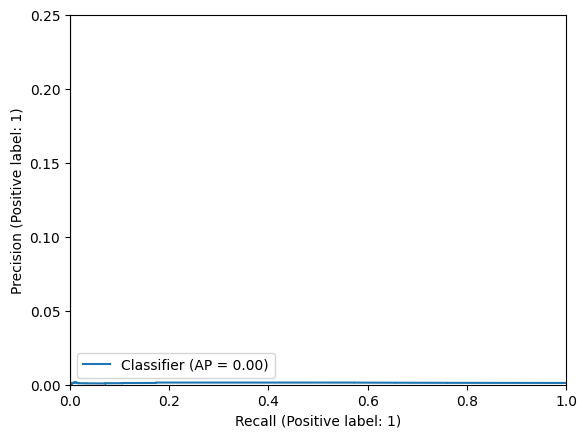

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
p_r_curve = PrecisionRecallDisplay.from_predictions(y_test_masked, y_pred)
plt.axis((0., 1., 0., 0.25));

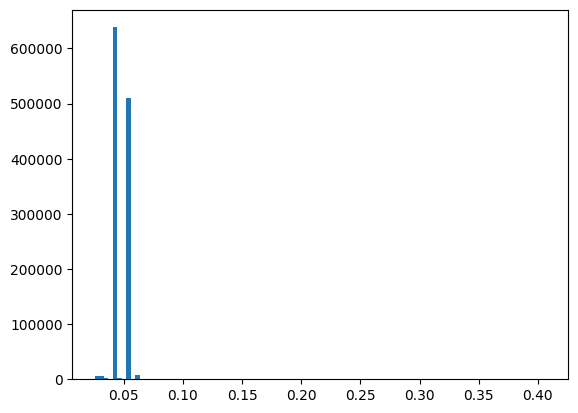

In [ ]:
plt.hist(y_pred, bins=100);

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

sorted_idx = np.argsort(y_pred)
fixed_label = np.zeros_like(y_pred)
fixed_label[-int(10*np.sum(y_test_masked)):] = 1
print(classification_report(y_test_masked[sorted_idx], fixed_label))
print(confusion_matrix(y_test_masked[sorted_idx], fixed_label))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99   1175292
         1.0       0.00      0.01      0.00      1415

    accuracy                           0.99   1176707
   macro avg       0.50      0.50      0.50   1176707
weighted avg       1.00      0.99      0.99   1176707

[[1161161   14131]
 [   1396      19]]


In [ ]:
np.sum(y_train)

user        2628743036
is_fraud          3228
dtype: int64

In [ ]:
drive.flush_and_unmount()